In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.model_selection import train_test_split

%matplotlib inline

In [43]:
forex = pd.read_csv('prep_forex.csv', header=[0,1], index_col=0)
index = pd.read_csv('prep_index.csv', header=[0,1,2], index_col=0)

In [73]:
cur = ('BDT')
transf = None
shuffle = False

if(isinstance(cur, tuple)):
    forex_pairs = list(set([x[1] for x in forex.columns if x[0] == 'Close' and x[1] == cur[0]]))
    index_pairs = list(set([(x[1], x[2]) for x in index.columns if x[0] == 'Close' and x[1] == cur[0]]))
else:
    forex_pairs = list(set([x[1] for x in forex.columns if x[0] == 'Close' and x[1] == cur]))
    index_pairs = list(set([(x[1], x[2]) for x in index.columns if x[0] == 'Close' and x[1] == cur]))


metric = 'Close'
metrics = ['Open', 'Close', 'Low', 'High']
target = [metric]
features = ['Intraday_HL', 'Intraday_OC', 'Prev_close_open'] + [y+x for x in ['', '_Ret', '_Ret_MA_3', '_Ret_MA_15', '_Ret_MA_45', '_MTD', '_YTD'] for y in metrics]# if (x+y) not in target]


In [74]:
def split_scale(X, y, scaler, shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=shuffle, test_size=0.2)
    if(scaler is None):
        return(X_train, X_test, y_train, y_test)
    else:
        scaler_X = scaler()
        if(scaler == scalers[-1]):
            scaler_X = scaler(np.log1p)
        scaler_X = scaler_X.fit(X_train)
        X_train = scaler_X.transform(X_train)
        X_test = scaler_X.transform(X_test)
        scaler_y = scaler()
        if(scaler == scalers[-1]):
            scaler_y = scaler(np.log1p)
        scaler_y = scaler_y.fit(y_train)
        y_train = scaler_y.transform(y_train)
        y_test = scaler_y.transform(y_test)
        return(X_train, X_test, y_train, y_test)

In [75]:
if(isinstance(cur, tuple)):
    index_cols = [x for x in index.columns if x[1] == cur[0] and x[2] == cur[1]]
    X = index[[col for col in index_cols if col[0] in features + ['Time features']]][:-1]
    y = index[[col for col in index_cols if col[0] in target]].shift(-1)[:-1]
else:
    forex_cols = [x for x in forex.columns if x[1] == cur]
    X = forex[[col for col in forex_cols if col[0] in features + ['Time features']]][:-1]
    y = forex[[col for col in forex_cols if col[0] in target]].shift(-1)[:-1]
X_train, X_test, y_train, y_test = split_scale(X, y, transf, shuffle)

In [76]:
y_train = y_train.reset_index()
y_train.columns = ['ds', 'y']
y_train.head()

,ds,y
0,2010-01-01,68.825
1,2010-01-04,68.875
2,2010-01-05,69.105
3,2010-01-06,69.105
4,2010-01-07,69.105


In [77]:
m = Prophet()
# m.add_seasonality(name='yearly', period='20', fourier_order=5)
m.fit(y_train)
future = m.make_future_dataframe(len(y_test))
# future['cap'] = 8
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [78]:
res = pd.concat([y.reset_index(drop=True), forecast['yhat']], axis=1, ignore_index=True)
res.index = y.index
res.columns = ['y_true', 'y_pred']
res.head()

,y_true,y_pred
Date,,
2010-01-01,68.825,68.943009
2010-01-04,68.875,68.962220
2010-01-05,69.105,68.977740
2010-01-06,69.105,68.951322
2010-01-07,69.105,68.956380


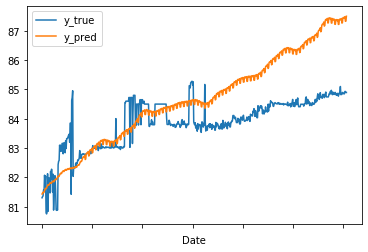

In [79]:
res.iloc[2000:,:].plot()

In [80]:
if(target[0][-3:] == 'Ret'):
    ret_res = np.sign(res)
else:
    ret_res = np.sres.pct_change()
    print(ret_res)

In [82]:
np.sign(ret_res)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in sign



,y_true,y_pred
Date,,
2010-01-01,NaN,NaN
2010-01-04,1.0,1.0
2010-01-05,1.0,1.0
2010-01-06,0.0,-1.0
2010-01-07,0.0,1.0
2010-01-08,0.0,1.0
2010-01-11,0.0,1.0
2010-01-12,0.0,1.0
2010-01-13,0.0,-1.0


In [72]:
to_save = pd.concat([ret_res, res], axis=1)
to_save.columns = ['y_true_class', 'y_pred_class', 'y_true_reg', 'y_pred_reg']
to_save.to_csv(str(cur)+"_"+target[0]+"_prophet.csv")